In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#%cd drive/MyDrive/mva/remotesensing

In [3]:
#!pip install geopandas rasterio

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import json

In [5]:
from pathlib import Path

data_folder = Path().absolute().parent / "data"
print(data_folder)

/home/agarnier/Documents/code/propios/ens/MVA-rs-project/data


#### Loading an image using rasterio

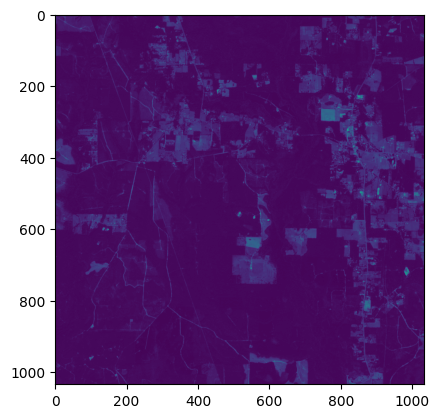

In [6]:
# Get path to raster

path_to_raster = data_folder / "sentinel-2/tx=37,ty=-332/20221010_B04.tif"
with rasterio.open(path_to_raster) as raster:
    
    # using the read function from rasterio you can read any bands contained in the raster
    # Every raster a single-channelled in this cases study, you can then read the content of the
    # raster as follows
    red = raster.read(1)/10_000
    plt.imshow(red)

#### Creating indices

A common processing step used in remote sensing is to work on indices rather than row data. This allows us to reduce the impact of the atmosphere and easily access meaningful features. Feel free to check https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/ to get more insights on the most common indices 

In [7]:
import cv2

In [8]:
def get_index(band1, band2):
    shape_1 = band1.shape
    shape_2 = band2.shape
    if np.sum(shape_1)>np.sum(shape_2):
        band2 = cv2.resize(band2, (shape_1[0], shape_1[1]))
    if np.sum(shape_2)>np.sum(shape_2):
        band1 = cv2.resize(band1, (shape_2[0], shape_2[1]))
    return (band1 - band2) / (band1 + band2 + 1e-5)


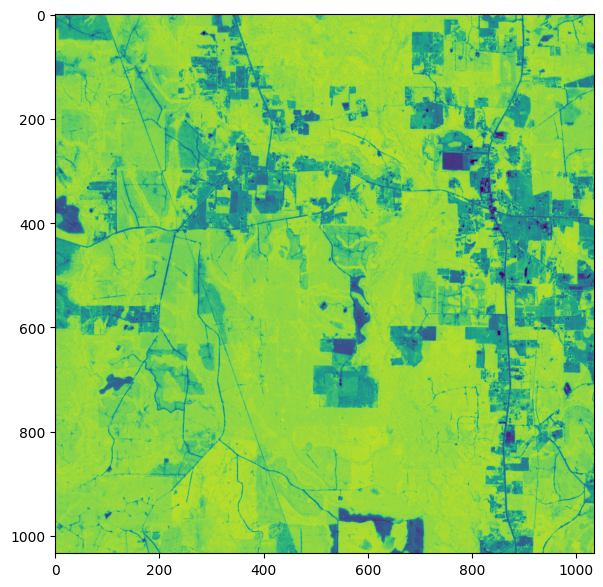

In [9]:
path_to_B04 = data_folder / "sentinel-2/tx=37,ty=-332/20221010_B04.tif"
path_to_B08 = data_folder / "sentinel-2/tx=37,ty=-332/20221010_B08.tif"
B04 = rasterio.open(path_to_B04).read(1)/10000
B08 = rasterio.open(path_to_B08).read(1)/10000
ndvi = get_index(B08, B04)
plt.figure(figsize=(7,7))
plt.imshow(ndvi, vmin=0, vmax=1)
plt.show()

#### Loading ground truth data

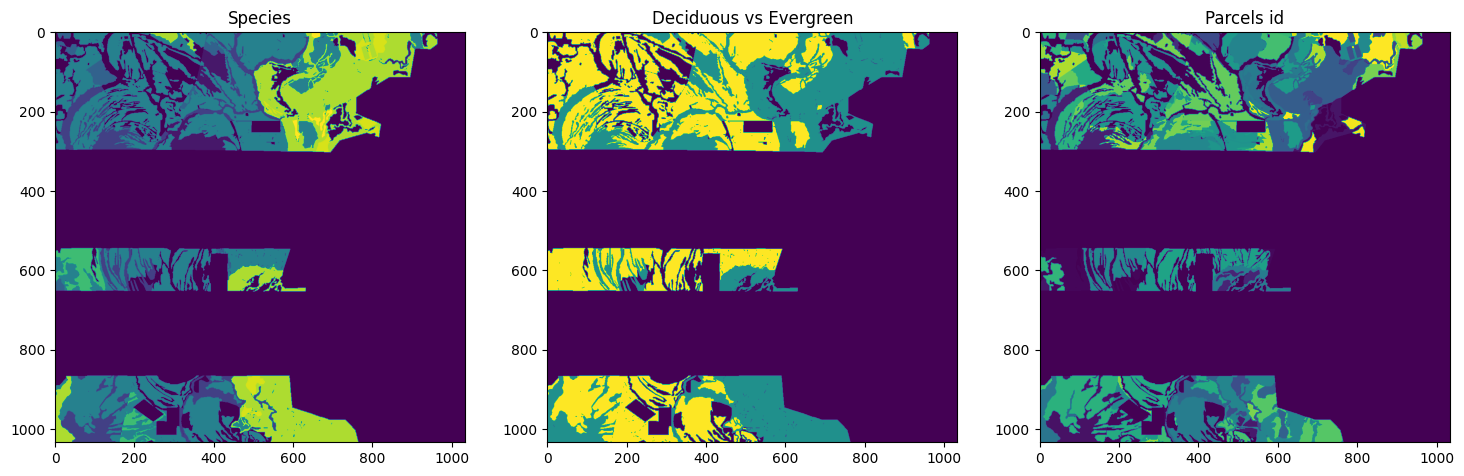

In [10]:
# Get path to raster
path_to_raster = data_folder / "ground_truth/tx=38,ty=-331.tif"
raster =  rasterio.open(path_to_raster)

species = raster.read(1)
deciduous_evergreen = raster.read(2)
parcel_id = raster.read(3)

# replacing nodata values
mask = (parcel_id==9999)
species[mask]=-1
deciduous_evergreen[mask]=-1
parcel_id[mask]=-1

fig, ax = plt.subplots(1,3, figsize=(18,7))
ax[0].imshow(species)
ax[0].set_title("Species")
ax[1].imshow(deciduous_evergreen)
ax[1].set_title("Deciduous vs Evergreen")
ax[2].imshow(parcel_id)
ax[2].set_title("Parcels id")
plt.show()

### Get relation between species id and names

In [11]:
species_indexing = json.load(open(data_folder / "ground_truth/species_indexing.json"))
deciduous_evergreen_indexing = json.load(open(data_folder / "ground_truth/deciduous_evergreen_indexing.json"))
print(species_indexing)
print()
print(deciduous_evergreen_indexing)

{'6': 'pinus taeda', '2': 'nyssa sylvatica', '0': 'cypress', '13': 'quercus nigra', '14': 'quercus pagoda', '3': 'pinus echinata', '4': 'pinus elliottii', '10': 'quercus laurifolia', '16': 'quercus rubra', '1': 'liquidambar', '5': 'pinus palustris', '15': 'quercus phellos', '8': 'quercus acutissima', '12': 'quercus michauxii', '17': 'quercus shumardii', '11': 'quercus lyrata', '18': 'triadica sebifera', '9': 'quercus falcata', '7': 'pseudotsuga menziesii'}

{'1': 'evergreen', '0': 'deciduous'}


### Usefull links

* Sentinel-2 bands : 
    * https://gisgeography.com/sentinel-2-bands-combinations/
* Sentinel-2 indices : 
    * https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/
* Tree Species Classification with Multi-Temporal Sentinel-2 Data : 
    * https://www.mdpi.com/2072-4292/10/11/1794
* Rasterio documentation : 
    * https://rasterio.readthedocs.io/en/latest/index.html

In [12]:
import os, glob
import datetime
from collections import defaultdict
import re

In [13]:
from skimage.transform import resize


In [14]:
def time_series(data_dir, ground_truth_dir, coordinates, agg_fn=np.mean):

  # store data in a dict (to be converted to pd.DataFrame later)
  data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: np.nan)))

  for coordinate in coordinates:
    parcel_ids = rasterio.open(os.path.join(ground_truth_dir, coordinate+'.tif')).read(3)

    for f in glob.iglob(os.path.join(data_dir, coordinate, '*_B*.tif')):
      img = rasterio.open(f).read(1)/10000

      # some bands have different sizes / pixel resolution (e.g. B11)
      for id in np.unique(parcel_ids):
        if parcel_ids.shape == img.shape:
          value = agg_fn(img[parcel_ids == id])
        else:
          value = agg_fn(resize(img, parcel_ids.shape)[parcel_ids == id])

        # extract band and date info from filename
        date, band = re.findall('[0-9]{8}_B[0-9]{2}', f)[0].split('_')
        date = datetime.datetime.strptime(date, '%Y%m%d').date()

        data[coordinate][(band,id)][date] = value
      
  return data

In [15]:
def simple_index(img_dict, bands):
  band1, band2 = (img_dict[bb] for bb in bands)
  shape_1 = band1.shape
  shape_2 = band2.shape
  if np.sum(shape_1)>np.sum(shape_2):
      band2 = cv2.resize(band2, (shape_1[0], shape_1[1]))
  if np.sum(shape_2)>np.sum(shape_2):
      band1 = cv2.resize(band1, (shape_2[0], shape_2[1]))
  return (band1 - band2) / (band1 + band2 + 1e-7)

def evi(img_dict, bands):
  B08, B04, B02 = (img_dict[bb] for bb in bands)
  return 2.5 * (B08 - B04) / (B08 + 6 * B04 - 7.5 * B02 + 1 + 1e-7)

def avi(img_dict, bands):
  B08, B04 = (img_dict[bb] for bb in bands)
  base = (B08 * (1 - B04)*(B08 - B04))
  return np.sign(base) * np.abs(base) ** (1/3)

In [16]:
def index_time_series(data_dir, ground_truth_dir, coordinates, indices, agg_fns=[np.mean]):

  # store data in a dict (to be converted to pd.DataFrame later)
  data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: np.nan)))

  band_list = set(bb for b in indices.values() for bb in b[1])

  for coordinate in coordinates:
    parcel_ids = rasterio.open(os.path.join(ground_truth_dir, coordinate+'.tif')).read(3)

    for date in set(f.split('_')[-2].split('/')[-1] for f in glob.iglob(os.path.join(data_dir, coordinate, '*_B*.tif'))):
      
      clouds = rasterio.open(os.path.join(data_dir, coordinate, f'{date}_SCL.tif')).read(1).astype(bool)
      
      bands = {
          band: rasterio.open(os.path.join(data_dir, coordinate, f'{date}_{band}.tif')).read(1)/10000
          for band in band_list
      }

      date = datetime.datetime.strptime(date, '%Y%m%d').date()

      for index, (fun, args) in indices.items():
        img = fun(bands, args)
        for id in set(parcel_ids.flatten()) - {9999}:
          pixel_coords = (parcel_ids == id) & ~clouds
          if pixel_coords.any():
            for agg_fn in agg_fns:
              data[coordinate][(index, agg_fn.__name__, id)][date] = agg_fn(img[pixel_coords])
      
  return pd.concat([
      pd.DataFrame(v, columns=pd.MultiIndex.from_tuples(v.keys(), names=["band", "agg", "parcel"])) 
      for v in data.values()], axis='columns').sort_index()

In [17]:
indices = {
    'ndvi': (simple_index, ('B08', 'B04')),
    'gndvi': (simple_index, ('B08', 'B03')),
    'ndmi': (simple_index, ('B08', 'B11')),
    'evi': (evi, ('B08', 'B04', 'B02')),
    'avi': (avi, ('B08', 'B04')),
}

In [18]:
#index_df = index_time_series(
#    data_dir = data_folder / 'sentinel-2', 
#    ground_truth_dir = data_folder / 'ground_truth', 
#    coordinates = [os.path.basename(d) for d in data_folder.glob('sentinel-2/*')],
#    indices = indices,
#    agg_fns = [np.mean, np.std, np.median]
#)

In [19]:
#index_df.to_pickle('../index_all_data.pkl')

---
To deal with later: some parcels may stretch over multiple tiffs:

In [20]:
all_ids = []
for gt in data_folder.glob('ground_truth/*.tif'):
    parcel_id = rasterio.open(gt).read(3)
    all_ids.extend(np.unique(parcel_id).tolist())

In [21]:
len(all_ids)

548

In [22]:
len(set(all_ids))

485

---

# Classes

In [23]:
def classes(ground_truth_dir, coordinates):

  species_dict = {}
  deciduous_evergreen_dict = {}
  
  for coordinate in coordinates:
    raster = rasterio.open(os.path.join(ground_truth_dir, coordinate+'.tif'))
    species = raster.read(1)
    deciduous_evergreen = raster.read(2)
    parcel_id = raster.read(3)

    for id in set(parcel_id.flatten()) - {9999}:
      species_dict[id] = np.unique(species[parcel_id == id]).item()
      deciduous_evergreen_dict[id] = np.unique(deciduous_evergreen[parcel_id == id]).item()
    
  return species_dict, deciduous_evergreen_dict

In [24]:
species_dict, deciduous_evergreen_dict = classes(
  ground_truth_dir = data_folder /'ground_truth', 
  coordinates = [os.path.basename(d) for d in data_folder.glob('sentinel-2/*')])

In [25]:
pd.Series(deciduous_evergreen_dict).value_counts(normalize=True)

1    0.780992
0    0.219008
dtype: float64

In [26]:
pd.Series(species_dict).value_counts(normalize=False)

6     349
13     52
0      17
4      16
14     11
5      10
2      10
1       8
15      5
10      3
16      1
8       1
9       1
dtype: int64

In [27]:
pd.Series(species_dict).value_counts(normalize=True)

6     0.721074
13    0.107438
0     0.035124
4     0.033058
14    0.022727
5     0.020661
2     0.020661
1     0.016529
15    0.010331
10    0.006198
16    0.002066
8     0.002066
9     0.002066
dtype: float64

In [28]:
def parcel_area(ground_truth_dir, coordinates):

  area = defaultdict(lambda: 0)
  
  for coordinate in coordinates:
    raster = rasterio.open(os.path.join(ground_truth_dir, coordinate+'.tif'))
    parcel_id = raster.read(3)

    for id in np.unique(parcel_id):
      area[id] += (parcel_id == id).sum()
    
  return dict(area)

In [29]:
parcel_area_dict = parcel_area(
  ground_truth_dir= data_folder / 'ground_truth', 
  coordinates= [os.path.basename(d) for d in data_folder.glob('sentinel-2/*')])

In [30]:
#pd.concat([
#    pd.Series(species_dict).astype(str).replace(species_indexing).value_counts().drop('9999').rename('parcels'),
#    pd.concat([pd.Series(species_dict).astype(str).replace(species_indexing), pd.Series(parcel_area_dict)], axis=1).groupby(0).sum()[1].drop('9999').rename('area')
#], axis=1).to_markdown()


---

# Feature extraction

In [31]:
index_df = pd.read_pickle('../index_all_data.pkl')

In [32]:
index_df.head()

band            ndvi                                                    \
agg             mean       std    median      mean       std    median   
parcel          256       256       256       258       258       258    
2018-12-10       NaN       NaN       NaN       NaN       NaN       NaN   
2018-12-15  0.763061  0.061463  0.767939  0.760521  0.062502  0.766352   
2019-01-24  0.752154  0.079560  0.760612  0.756670  0.070261  0.758225   
2019-01-29  0.748930  0.080051  0.757526  0.753889  0.066198  0.754567   
2019-02-13  0.720493  0.079813  0.729528  0.731977  0.067027  0.732007   

band                                                ...       avi            \
agg             mean       std    median      mean  ...    median      mean   
parcel          777       777       777       525   ...      1771      2162   
2018-12-10       NaN       NaN       NaN       NaN  ...  0.275551  0.242338   
2018-12-15  0.831276  0.038841  0.839114  0.782661  ...       NaN       NaN   
2019-01-24  0.845628  0.054179  0.858055  0.790839  ...  0.260398  0.241023   
2019-01-29  0.835766  0.061111  0.851654  0.782162  ...  0.269536  0.256543   
2019-02-13  0.816538  0.051655  0.828741  0.754625  ...  0.269132  0.250486   

band                                                                    \
agg              std    median      mean       std    median      mean   
parcel          2162      2162      630       630       630       2041   
2018-12-10  0.034537  0.233456  0.334550  0.024856  0.336783  0.285234   
2018-12-15       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-24  0.023280  0.238077  0.338780  0.024356  0.340901  0.269688   
2019-01-29  0.029135  0.249513  0.347567  0.023722  0.349379  0.267059   
2019-02-13  0.018439  0.249227  0.344653  0.021968  0.347241  0.274997   

band                            
agg              std    median  
parcel          2041      2041  
2018-12-10  0.061064  0.294853  
2018-12-15       NaN       NaN  
2019-01-24  0.050665  0.267261  
2019-01-29  0.048958  0.266507  
2019-02-13  0.043472  0.271139  

[5 rows x 8115 columns]

In [33]:
def winter_over_summer(df):

  winter = df.loc[[m in (12,1,2) for m in pd.DatetimeIndex(df.index).month]].mean()
  summer = df.loc[[m in  (6,7,8) for m in pd.DatetimeIndex(df.index).month]].mean()

  return winter / summer

In [34]:
def winter_diff_summer(df):

  winter = df.loc[[m in (12,1,2) for m in pd.DatetimeIndex(df.index).month]].mean()
  summer = df.loc[[m in  (6,7,8) for m in pd.DatetimeIndex(df.index).month]].mean()

  return summer - winter

In [35]:
def median_derivative(df):
  return df.diff().median()
  # return (df.diff().T / df.index.to_series().diff().dt.days.T).T.median()

In [36]:
def std_derivative(df):
  return df.diff().std()
  # return (df.diff().T / df.index.to_series().diff().dt.days.T).T.median()

In [37]:
def doy_max(df):
  return pd.to_datetime(df.idxmax() + datetime.timedelta(days=31)).dt.day_of_year

In [38]:
def doy_min(df):
  return pd.to_datetime(df.idxmin() + datetime.timedelta(days=31)).dt.day_of_year

In [39]:
def doy_max_derivative(df):
  return pd.to_datetime((df.diff().T / df.index.to_series().diff().dt.days.T).T.idxmax() + datetime.timedelta(days=31)).dt.day_of_year

In [40]:
def min_max_diff(df):
  return df.max() - df.min()

In [41]:
def feature_extraction(df, feature_list):
  X = pd.concat([fun(df[index][agg]) for (fun, index, agg) in feature_list], axis=1)
  X.columns = [index + '_' + agg + '__' + fun.__name__ for (fun, index, agg) in feature_list]
  return X

In [42]:
import itertools

In [43]:
# list of (function, index, agg) tuples
features = list(itertools.product([
    doy_max, 
    # doy_min,
    # doy_max_derivative,
    median_derivative,
    std_derivative,
    winter_over_summer,
    winter_diff_summer,
    pd.DataFrame.std,
    pd.DataFrame.min,
    pd.DataFrame.max,
    min_max_diff,
    pd.DataFrame.mean,
], ['ndvi', 'gndvi', 'ndmi', 'evi', 'avi'],
   ['mean', 'std', 'median']))

---
# Classification: deciduous vs. evergreen

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier

In [45]:
Xy = pd.concat([feature_extraction(index_df, features), pd.Series(deciduous_evergreen_dict)], axis=1)
Xy = Xy.loc[Xy.index != 9999]
X = Xy.iloc[:,:-1]
y = Xy.iloc[:,-1]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [47]:
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

In [48]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [49]:
accuracy_score(y_test, y_pred)

0.9664804469273743

In [50]:
roc_auc_score(y_test, y_pred)

0.9703334423014057

In [51]:
confusion_matrix(y_test, y_pred)

array([[ 45,   1],
       [  5, 128]])

# Classification: species

In [52]:
Xy = pd.concat([feature_extraction(index_df, features), pd.Series(species_dict)], axis=1)
Xy = Xy.loc[Xy.index != 9999]
X = Xy.iloc[:,:-1].to_numpy()
y = Xy.iloc[:,-1].to_numpy()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [54]:
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

In [55]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [56]:
accuracy_score(y_test, y_pred)

0.8268156424581006

In [57]:
balanced_accuracy_score(y_test, y_pred)

0.23961519272900808

---

## Yearly time series

In [58]:
yearly_df = pd.concat([
    index_df.interpolate().loc[datetime.datetime.strptime(f'{y}1201', '%Y%m%d').date():datetime.datetime.strptime(f'{y+1}1130', '%Y%m%d').date()]
    for y in range(index_df.index.min().year, index_df.index.max().year)
], axis=1)

In [59]:
# yearly_df = yearly_df.set_index((pd.DatetimeIndex(yearly_df.index)+datetime.timedelta(days=31)).day_of_year).groupby(level=0).median()
# yearly_df.set_index()

In [60]:
yearly_df

band            ndvi                                                    \
agg             mean       std    median      mean       std    median   
parcel          256       256       256       258       258       258    
2018-12-10       NaN       NaN       NaN       NaN       NaN       NaN   
2018-12-15  0.763061  0.061463  0.767939  0.760521  0.062502  0.766352   
2019-01-24  0.752154  0.079560  0.760612  0.756670  0.070261  0.758225   
2019-01-29  0.748930  0.080051  0.757526  0.753889  0.066198  0.754567   
2019-02-13  0.720493  0.079813  0.729528  0.731977  0.067027  0.732007   
...              ...       ...       ...       ...       ...       ...   
2022-10-10       NaN       NaN       NaN       NaN       NaN       NaN   
2022-10-15       NaN       NaN       NaN       NaN       NaN       NaN   
2022-10-20       NaN       NaN       NaN       NaN       NaN       NaN   
2022-10-25       NaN       NaN       NaN       NaN       NaN       NaN   
2022-11-09       NaN       NaN       NaN       NaN       NaN       NaN   

band                                                ...       avi            \
agg             mean       std    median      mean  ...    median      mean   
parcel          777       777       777       525   ...      1771      2162   
2018-12-10       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2018-12-15  0.831276  0.038841  0.839114  0.782661  ...       NaN       NaN   
2019-01-24  0.845628  0.054179  0.858055  0.790839  ...       NaN       NaN   
2019-01-29  0.835766  0.061111  0.851654  0.782162  ...       NaN       NaN   
2019-02-13  0.816538  0.051655  0.828741  0.754625  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2022-10-10       NaN       NaN       NaN       NaN  ...  0.354277  0.381759   
2022-10-15       NaN       NaN       NaN       NaN  ...  0.346870  0.375877   
2022-10-20       NaN       NaN       NaN       NaN  ...  0.348306  0.375687   
2022-10-25       NaN       NaN       NaN       NaN  ...  0.347675  0.375416   
2022-11-09       NaN       NaN       NaN       NaN  ...  0.347675  0.375416   

band                                                                    \
agg              std    median      mean       std    median      mean   
parcel          2162      2162      630       630       630       2041   
2018-12-10       NaN       NaN       NaN       NaN       NaN       NaN   
2018-12-15       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-24       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-29       NaN       NaN       NaN       NaN       NaN       NaN   
2019-02-13       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-10-10  0.022742  0.383515  0.331458  0.018390  0.331803  0.348251   
2022-10-15  0.023520  0.377582  0.329322  0.018545  0.329870  0.343933   
2022-10-20  0.025799  0.378516  0.334495  0.020103  0.335032  0.340194   
2022-10-25  0.027656  0.378751  0.333977  0.020719  0.334929  0.340006   
2022-11-09  0.027656  0.378751  0.333977  0.020719  0.334929  0.340006   

band                            
agg              std    median  
parcel          2041      2041  
2018-12-10       NaN       NaN  
2018-12-15       NaN       NaN  
2019-01-24       NaN       NaN  
2019-01-29       NaN       NaN  
2019-02-13       NaN       NaN  
...              ...       ...  
2022-10-10  0.032867  0.346802  
2022-10-15  0.034639  0.341983  
2022-10-20  0.034641  0.340669  
2022-10-25  0.039956  0.337607  
2022-11-09  0.039956  0.337607  

[90 rows x 32460 columns]

In [61]:
# Xy = pd.concat([feature_extraction(yearly_df, features), feature_extraction(yearly_std_df, features, suffix='_std'), pd.Series(species_dict)], axis=1)
# Xy = pd.concat([feature_extraction(yearly_median_df, features), pd.Series(species_dict)], axis=1)
Xy = pd.concat([feature_extraction(yearly_df, features), pd.Series(species_dict)], axis=1)
Xy = Xy.loc[Xy.index != 9999]
X = Xy.iloc[:,:-1]
y = Xy.iloc[:,-1]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [63]:
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [64]:
accuracy_score(y_pred, y_test)

0.8335664335664336

In [65]:
balanced_accuracy_score(y_test, y_pred)

0.30750828096372823

In [66]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

0.9108609831647397

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

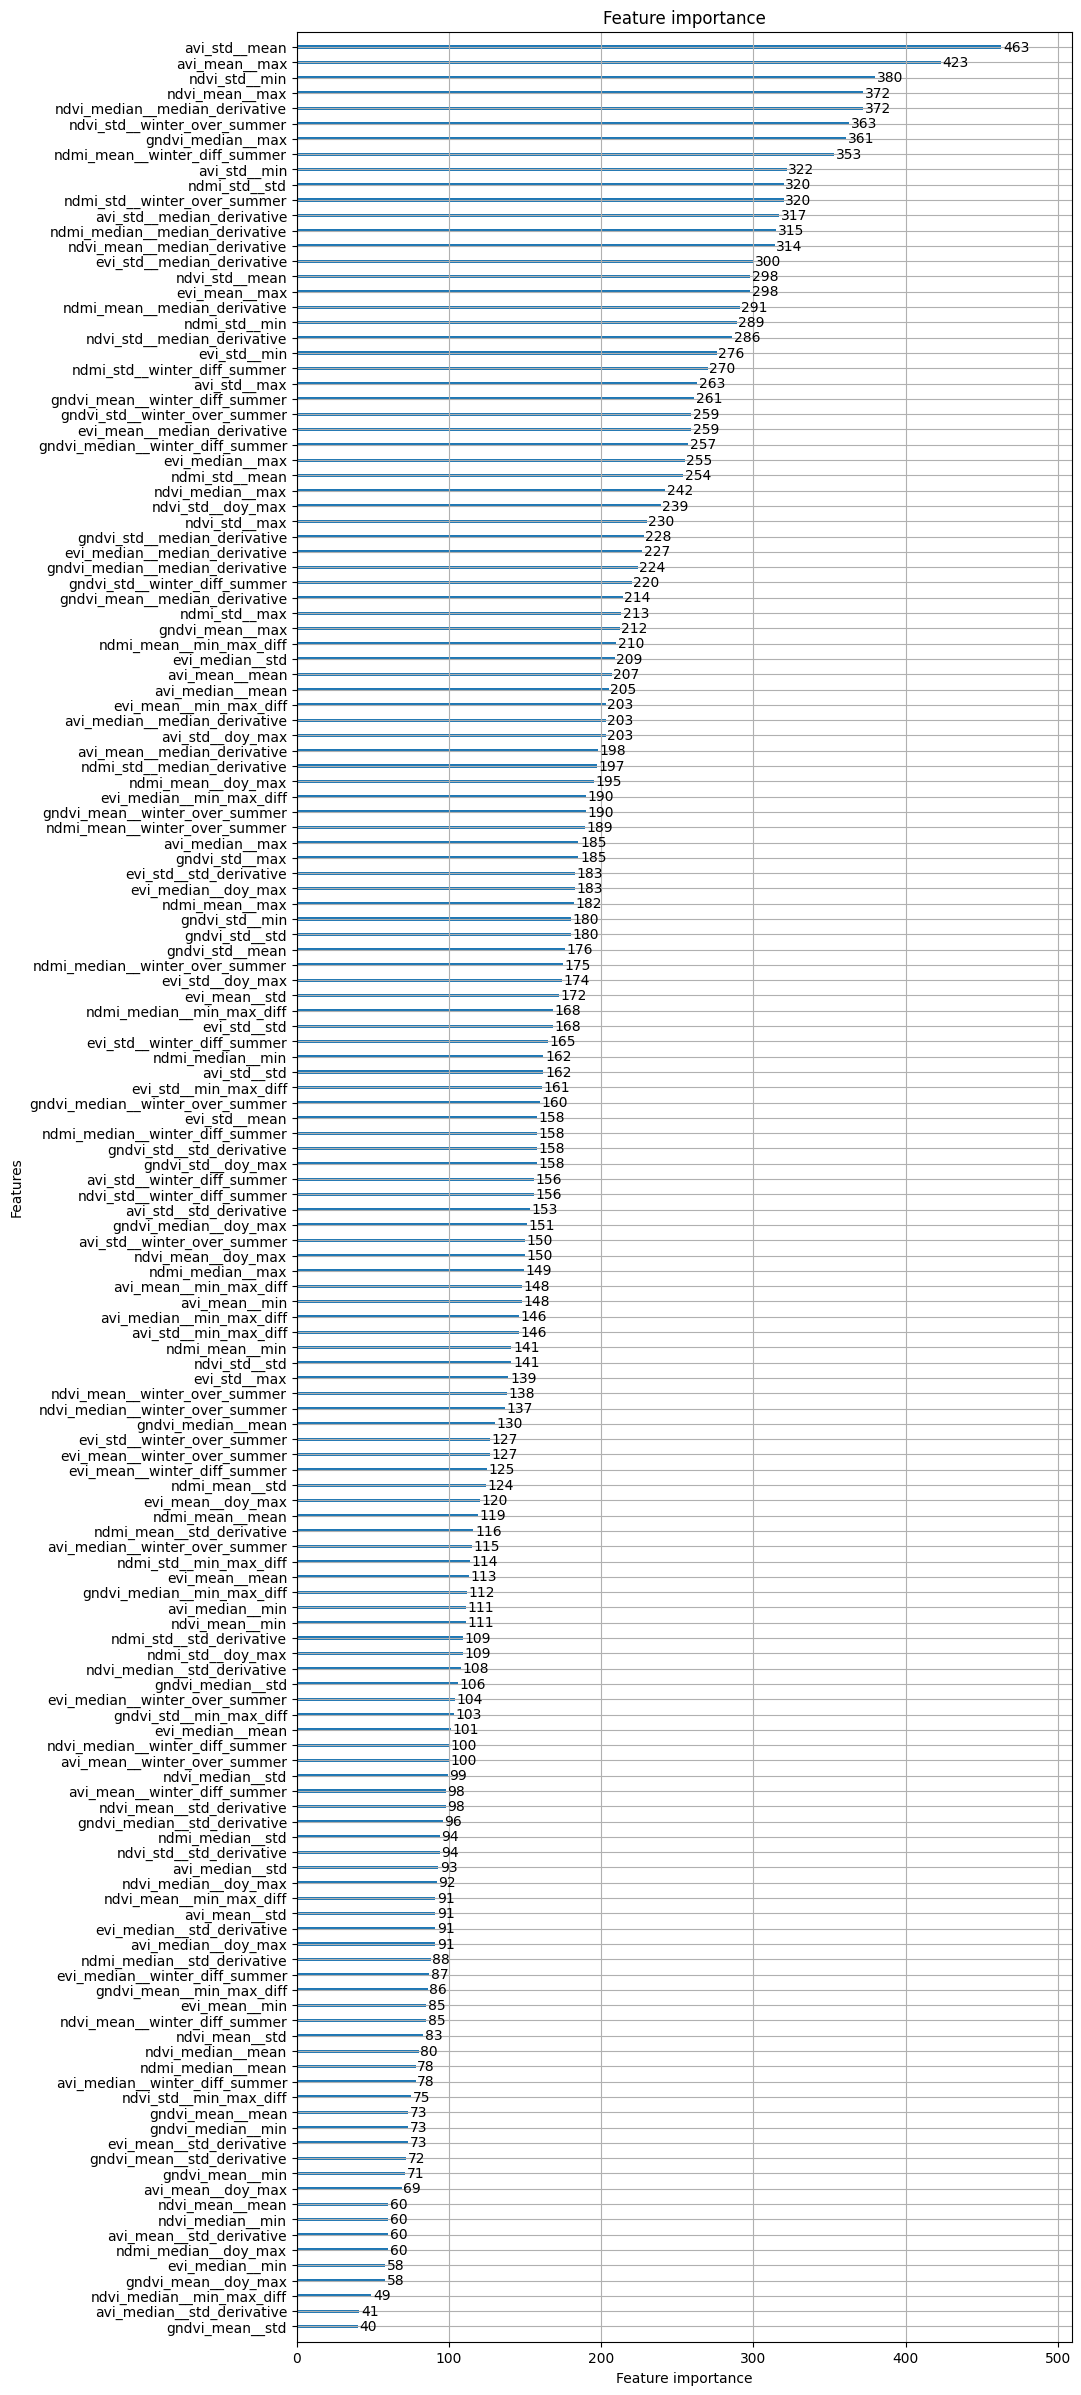

In [67]:
from lightgbm import plot_importance
plot_importance(model, figsize=(10,30))

In [68]:
np.array(model.feature_name_)[model.feature_importances_ == 0]

array([], dtype='<U32')

## Imbalance

In [69]:
#!pip install -U imbalanced-learn

In [70]:
from imblearn.over_sampling import RandomOverSampler

In [71]:
oversampler = RandomOverSampler()
X_over, y_over = oversampler.fit_resample(X_train, y_train)

In [72]:
model = LGBMClassifier()
model.fit(X_over, y_over)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [73]:
accuracy_score(y_test, y_pred)

0.8377622377622378

In [74]:
balanced_accuracy_score(y_test, y_pred)

0.34348922773478985

In [75]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

0.8828836808571192